In [1]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
pw = os.getcwd()
terminus_data_path = pw+"/../data/terminus_data/"        # folder where all the data for terminus position and terminus sections is stored
veloc_data_path    = pw+"/../data/velocity/"
weather_data_path  = pw+"/../data/weather/"
mooring_data_path  = pw+"/../data/mooring/"

In [3]:
# load datasets
df_veloc      = pd.read_csv(veloc_data_path+"velocity_by_section.csv")
df_terminus   = pd.read_csv(terminus_data_path+"retreat_by_section.csv")
df_weather    = pd.read_csv(weather_data_path+"compiled_weather_data_PDDs.csv")
df_mooring    = pd.read_csv(mooring_data_path+"GAK_smooth.csv")
# bring time vectors into right format
t                  = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in df_terminus.Date]
df_veloc.Date      = pd.to_datetime(df_veloc.Date)
df_terminus.Date   = pd.to_datetime(df_terminus.Date)
df_mooring.Date    = pd.to_datetime(df_mooring.Date)
df_weather["Date"] = pd.to_datetime(df_weather.iloc[:,0])  # already has a sample each day

In [17]:
idx = np.where((df_weather["Date"] >= np.min(df_veloc["Date"])) & (df_weather["Date"] <= np.max(df_veloc["Date"])))[0]
df_weather_short = df_weather.iloc[idx,:]
df_weather_short = df_weather_short.filter(items=["Date", "AirTempC_Yakutat"])

In [26]:
# resample/interpolate time series to daily values (so they can later be averaged over the year more easily) and average over section
df_all  = pd.DataFrame()
for (df, nam) in zip([df_veloc, df_terminus], ["velocity", "terminus"]):
    df = df.resample("d", on="Date").mean().interpolate()
    if df_all.empty:
        df_all["Date"] = df.index
    df_all[nam] = df.mean(axis=1).values
df_all = pd.merge(df_all, df_weather_short)
df_all = pd.merge(df_all, df_mooring.iloc[:,0:4])
df_all

,Date,velocity,terminus,AirTempC_Yakutat,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m
0,2017-04-12,2224.012926,173.212460,NaN,4.681443,4.399093,4.542344
1,2017-04-12,2224.012926,173.212460,NaN,4.681443,4.399093,4.542344
2,2017-04-12,2224.012926,173.212460,NaN,4.681443,4.399093,4.542344
3,2017-04-12,2224.012926,173.212460,NaN,4.681443,4.399093,4.542344
4,2017-04-12,2224.012926,173.212460,NaN,4.681443,4.399093,4.542344
...,...,...,...,...,...,...,...
107879,2020-05-10,2246.624108,106.388931,NaN,5.582201,4.919414,5.175003
107880,2020-05-10,2246.624108,106.388931,NaN,5.582201,4.919414,5.175003
107881,2020-05-10,2246.624108,106.388931,NaN,5.582201,4.919414,5.175003
107882,2020-05-10,2246.624108,106.388931,NaN,5.582201,4.919414,5.175003


In [73]:
# average over the year
tind    = [di.timetuple().tm_yday for di in df_all["Date"] ]   # day of the year
df_avyr = pd.DataFrame()
for col in df_all:
    if col == "Date":
        continue
    ds = []
    vls = []
    for dd in range(np.min(tind), np.max(tind)+1):
        val = np.mean(df_all[col][np.where(np.array(tind) == dd)[0]])
        # if dd > 220:
        #     dd = dd - np.max(tind)
        ds.append(dd)
        vls.append(val)
    if df_avyr.empty:
        df_avyr["Date"] = ds
    df_avyr[col] = vls
df_avyr

,Date,velocity,terminus,AirTempC_Yakutat,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m
0,1,2352.770964,247.739629,3.208192,5.858140,6.690355,7.480083
1,2,2356.183266,245.980168,-1.239723,5.812752,6.634801,7.452303
2,3,2359.595568,244.220706,-3.143194,5.768363,6.578583,7.424199
3,4,2360.294468,242.361160,-4.093642,5.725132,6.521776,7.395688
4,5,2360.993368,240.501614,NaN,5.683187,6.464483,7.366704
...,...,...,...,...,...,...,...
360,361,2327.661917,256.298104,1.850629,6.094163,6.958197,7.616906
361,362,2335.097988,254.658059,4.194071,6.046207,6.905846,7.589594
362,363,2342.534058,253.018014,1.272744,5.998523,6.852902,7.562317
363,364,2345.946360,251.258553,4.106262,5.951191,6.799370,7.535016


In [94]:
def unique(x):
    return list(set(x))

# converting to date
strt_date = dt.date(int("2001"), 1, 1)
res_date = [strt_date + dt.timedelta(days=int(doy) - 1) for doy in np.sort(unique(tind))]
# res = [d.strftime("%Y-%m-%d") for d in res_date]
# tres = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in res]

[datetime.date(2001, 1, 1),
 datetime.date(2001, 1, 2),
 datetime.date(2001, 1, 3),
 datetime.date(2001, 1, 4),
 datetime.date(2001, 1, 5),
 datetime.date(2001, 1, 6),
 datetime.date(2001, 1, 7),
 datetime.date(2001, 1, 8),
 datetime.date(2001, 1, 9),
 datetime.date(2001, 1, 10),
 datetime.date(2001, 1, 11),
 datetime.date(2001, 1, 12),
 datetime.date(2001, 1, 13),
 datetime.date(2001, 1, 14),
 datetime.date(2001, 1, 15),
 datetime.date(2001, 1, 16),
 datetime.date(2001, 1, 17),
 datetime.date(2001, 1, 18),
 datetime.date(2001, 1, 19),
 datetime.date(2001, 1, 20),
 datetime.date(2001, 1, 21),
 datetime.date(2001, 1, 22),
 datetime.date(2001, 1, 23),
 datetime.date(2001, 1, 24),
 datetime.date(2001, 1, 25),
 datetime.date(2001, 1, 26),
 datetime.date(2001, 1, 27),
 datetime.date(2001, 1, 28),
 datetime.date(2001, 1, 29),
 datetime.date(2001, 1, 30),
 datetime.date(2001, 1, 31),
 datetime.date(2001, 2, 1),
 datetime.date(2001, 2, 2),
 datetime.date(2001, 2, 3),
 datetime.date(2001, 2, 4)

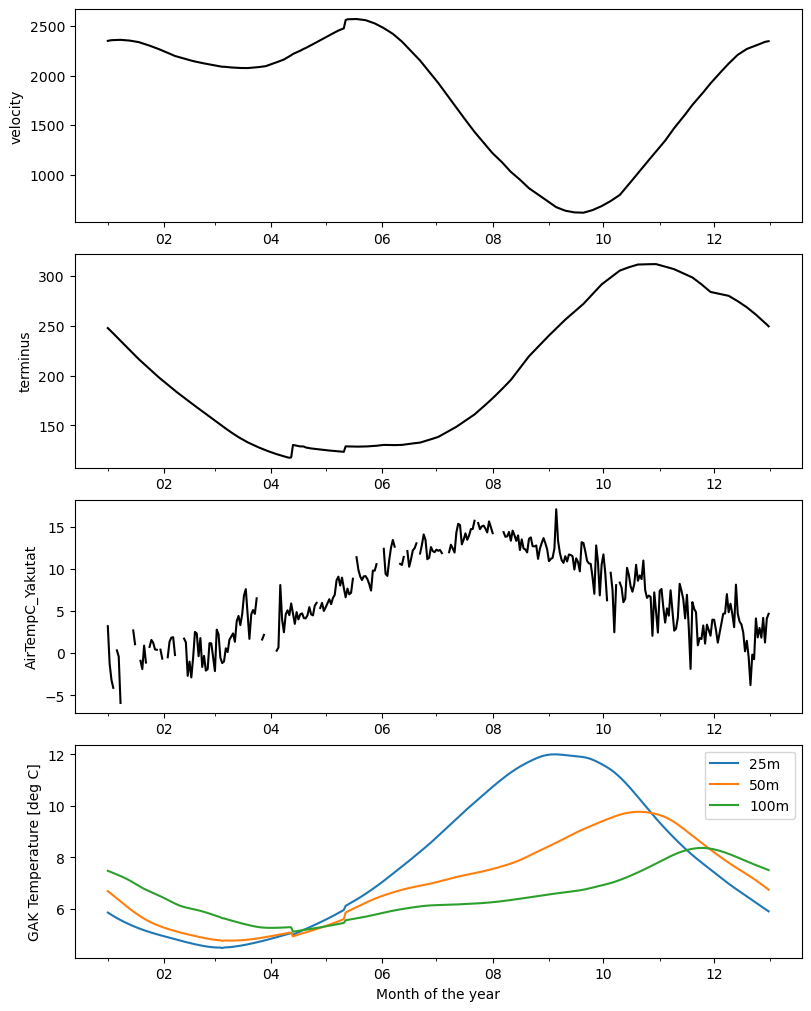

In [95]:
# can replace df_avyr by df_all to only average over sections and not year
fig, ax = plt.subplots(4,1, layout='constrained', figsize=(8,10))
i = 0
for col in df_avyr:
    if col == "Date":
        continue
    if col.startswith("Temperature"):
        i = 3
        ax[i].plot(res_date, df_avyr[col], label=col.split(" ")[-1]); ax[i].set_ylabel("GAK Temperature [deg C]"); ax[i].legend()
    else:
        ax[i].plot(res_date, df_avyr[col], color="black"); ax[i].set_ylabel(col)
        # ax[i].plot(df_avyr["Date"], df_avyr[col], 2, color="black"); ax[i].set_ylabel(col)

    ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2,4,6,8,10,12]))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m'))            # see https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
    if i == len(ax)-1:
        ax[i].set_xlabel("Month of the year")
    i+=1
    fig.savefig("four-panel-yearly.jpg")